##Step 1: Data Preparation

**Objective**: Load and clean Tadawul stock data.

In [38]:
import pandas as pd
# Load the dataset explicitly
df1 = pd.read_csv('Tadawul_stcks.csv')
df2 = pd.read_csv('Tadawul_stcks_23_4.csv')
# Concatenate datasets explicitly
df = pd.concat([df1, df2])
# Fix column names (removing spaces explicitly)
df.columns = df.columns.str.strip()
# Select important columns explicitly
df = df[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume_traded']].copy()
# Convert the 'date' column to a datetime type explicitly
df['date'] = pd.to_datetime(df['date'])
# Sort data explicitly by stock symbol and date
df.sort_values(by=['symbol', 'date'], inplace=True)
# Remove rows with missing values explicitly
df.dropna(inplace=True)

## Step 2: Select a Specific Stock

**Objective**: Select data from a single stock for focused analysis.

In [39]:
# Choose a stock symbol explicitly (change this to any available symbol)
symbol_to_use = 1010  # Example symbol, you can change this!
stock_df = df[df['symbol'] == symbol_to_use].copy()

## Step 3: Creating Sequences

**Objective**: Transform data into sequences suitable for an RNN.

Remember, an RNN model learns from previous data points (e.g., the last 5 days) to predict future outcomes (the next day's price).

In [40]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Select relevant features explicitly
features = ['open', 'high', 'low', 'close', 'volume_traded']
data = stock_df[features].values
# Normalize data explicitly
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
# Create sequences explicitly (past 5 days predict the next day's closing price)
sequence_length = 5
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length])
    y.append(data_scaled[i+sequence_length][3])  # predicting close price explicitly
X, y = np.array(X), np.array(y)

## Step 4: Splitting Data

**Objective**: Split data explicitly into training and testing sets.



In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Order matters explicitly in sequential data
)

## Step 5: Defining the RNN Model

**Objective**: Define the structure of your RNN explicitly using PyTorch.

In [42]:
import torch

import torch.nn as nn
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
# Parameters explained:
input_size = 5       # (open, high, low, close, volume_traded)
hidden_size = 16     # Number of hidden neurons
output_size = 1      # Predicting the closing price explicitly
model = StockRNN(input_size, hidden_size, output_size)


## Step 6: Training the Model

**Objective**: Train your model explicitly to recognize patterns in sequential data.



In [43]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
num_epochs = 100

for epoch in range(num_epochs):
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [20/100], Loss: 0.003924
Epoch [40/100], Loss: 0.000534
Epoch [60/100], Loss: 0.000273
Epoch [80/100], Loss: 0.000201
Epoch [100/100], Loss: 0.000187


## Step 7: Evaluating the Model

**Objective**: Check model accuracy explicitly by predicting stock prices.



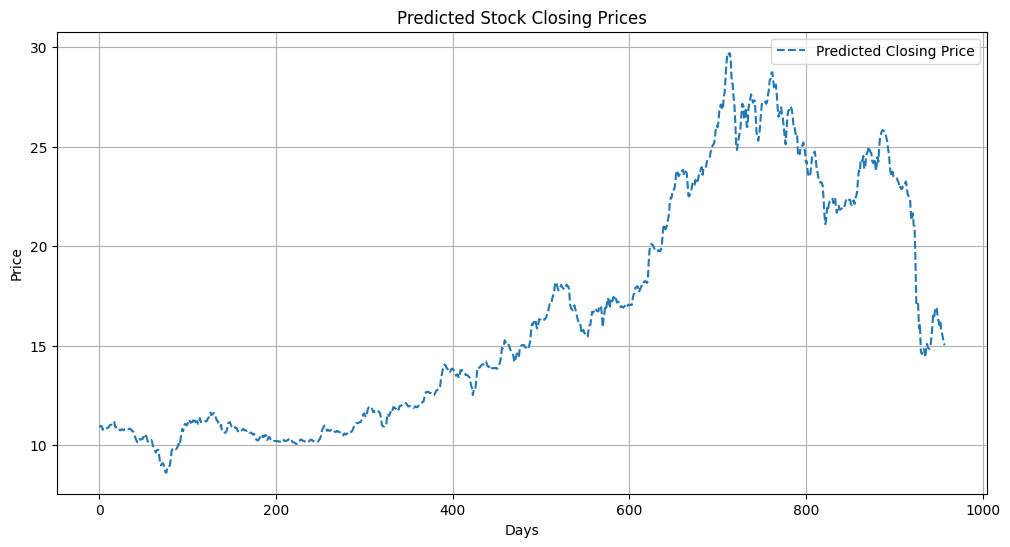

In [44]:
import matplotlib.pyplot as plt
model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    predictions = model(X_test_t).numpy()

# Inverse transform predictions explicitly to original price
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(predictions), 3)), predictions, np.zeros((len(predictions), 1))], axis=1)
)[:, 3]

plt.figure(figsize=(12, 6))
plt.plot(predictions_rescaled, label='Predicted Closing Price', linestyle='--')
plt.title('Predicted Stock Closing Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Extract last known sequence explicitly from full scaled dataset
last_known_sequence = data_scaled[-sequence_length:]
last_known_sequence = last_known_sequence.reshape(1, sequence_length, input_size)

# Convert to tensor
input_seq = torch.tensor(last_known_sequence, dtype=torch.float32)

In [46]:
# Number of days you want to forecast
forecast_days = 7
predictions = []
current_seq = input_seq.clone()
model.eval()
with torch.no_grad():
    for _ in range(forecast_days):
        next_pred = model(current_seq)
        predictions.append(next_pred.item())
        # Create new sequence with predicted close added at the end
        next_input = current_seq[:, 1:, :].clone()  # Drop first day

        # Simulate next input row (use same values for open/high/low/volume)
        next_step = current_seq[:, -1, :].clone()
        next_step[0, 3] = next_pred  # Replace close value with predicted one

        next_input = torch.cat([next_input, next_step.unsqueeze(1)], dim=1)
        current_seq = next_input


In [47]:
# Reconstruct shape expected by scaler for inverse transform
fake_input = np.zeros((forecast_days, 5))
fake_input[:, 3] = predictions  # Put predicted close in column index 3

# Inverse transform using original scaler
predicted_prices = scaler.inverse_transform(fake_input)[:, 3]  # Extract predicted close

# Print predictions
for i, price in enumerate(predicted_prices):
    print(f"Day {i+1}: Predicted Close = {price:.2f}")

Day 1: Predicted Close = 15.05
Day 2: Predicted Close = 15.09
Day 3: Predicted Close = 15.10
Day 4: Predicted Close = 15.09
Day 5: Predicted Close = 15.09
Day 6: Predicted Close = 15.09
Day 7: Predicted Close = 15.09


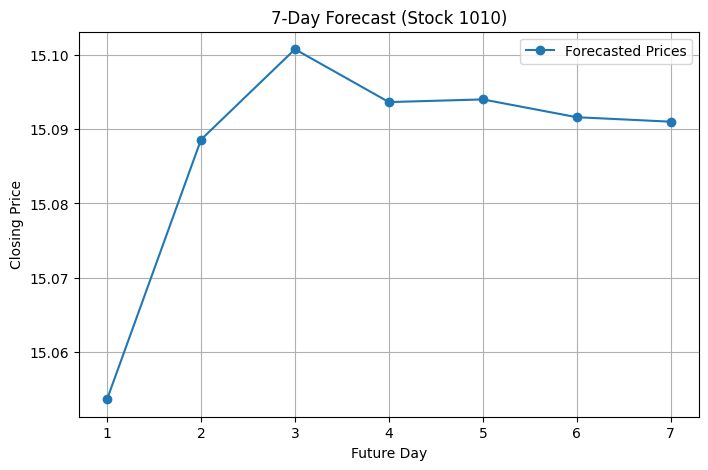

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, forecast_days+1), predicted_prices, marker='o', label='Forecasted Prices')
plt.title(f'{forecast_days}-Day Forecast (Stock {symbol_to_use})')
plt.xlabel('Future Day')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()